This example notebook will be a modified version of the ML tutorial given by Ben Nachman in the INDIA-CMS lecture meeting. The original notebook can be found here
https://github.com/bnachman/CMSIndiaDemo

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from sklearn.preprocessing import StandardScaler
import random

In [3]:
import pandas as pd

### Download the necessary datasets

Data from the LHC Olympics: https://lhco2020.github.io/homepage/

In [4]:
#!wget https://raw.githubusercontent.com/bnachman/CMSIndiaDemo/main/anomaly.csv
#!wget https://raw.githubusercontent.com/bnachman/CMSIndiaDemo/main/noisesimulation1.csv
#!wget https://raw.githubusercontent.com/bnachman/CMSIndiaDemo/main/noisesimulation2.csv

convert to pandas dataframe

In [5]:
df=pd.read_csv('anomaly.csv', sep=',',header=None)
df2=pd.read_csv('noisesimulation1.csv', sep=',',header=None)
df3=pd.read_csv('noisesimulation2.csv', sep=',', header=None)


In [6]:

#first feature is m_JJ, other features are jet masses and tau_21's.
sig = df.to_numpy()
back1 = df3.to_numpy() #one of these is Pythia and one is Herwig.
back2 = df2.to_numpy()


In [7]:

#Select only events in the signal region
sig = sig[(sig[:,0]>3.25)*(sig[:,0]<3.75)][:,1:5]
back1 = back1[(back1[:,0]>3.25)*(back1[:,0]<3.75)][:,1:5]
back2 = back2[(back2[:,0]>3.25)*(back2[:,0]<3.75)][:,1:5]

In [8]:
## Transforming variables
scaler = StandardScaler()
scaler.fit(back1)
sig = scaler.transform(sig)
back1 = scaler.transform(back1)
back2 = scaler.transform(back2)


##### We will first use a supervised classifier(dnn) and then compare the performance with the unsupervised model

In [11]:
X_fs = np.concatenate([sig,back1])
Y_fs = np.concatenate([np.ones(len(sig)),np.zeros(len(back1))]) # assign labels

In [12]:

X_fs_train, X_fs_test, Y_fs_train, Y_fs_test = train_test_split(X_fs,Y_fs,test_size=0.2)

In [13]:
## Fully supervised classifier

model_fs = Sequential()
model_fs.add(Dense(100,input_dim=4,activation='relu'))
model_fs.add(Dense(100,activation='relu'))
model_fs.add(Dense(100,activation='relu'))
model_fs.add(Dense(1,activation='sigmoid'))
model_fs.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_fs.summary()


model_fs.fit(X_fs_train,Y_fs_train,epochs=25,batch_size=2000)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               500       
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 20,801
Trainable params: 20,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25


2022-08-28 12:17:29.415929: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


95/95 [==============================] - 1s 7ms/step - loss: 0.3632 - accuracy: 0.8654
Epoch 2/25
95/95 [==============================] - 1s 7ms/step - loss: 0.2578 - accuracy: 0.9020
Epoch 3/25
95/95 [==============================] - 1s 7ms/step - loss: 0.2351 - accuracy: 0.9095
Epoch 4/25
95/95 [==============================] - 1s 6ms/step - loss: 0.2297 - accuracy: 0.9120
Epoch 5/25
95/95 [==============================] - 0s 5ms/step - loss: 0.2287 - accuracy: 0.9121
Epoch 6/25
95/95 [==============================] - 0s 5ms/step - loss: 0.2273 - accuracy: 0.9129
Epoch 7/25
95/95 [==============================] - 0s 5ms/step - loss: 0.2262 - accuracy: 0.9134
Epoch 8/25
95/95 [==============================] - 0s 5ms/step - loss: 0.2256 - accuracy: 0.9134
Epoch 9/25
95/95 [==============================] - 0s 5ms/step - loss: 0.2249 - accuracy: 0.9139
Epoch 10/25
95/95 [==============================] - 0s 5ms/step - loss: 0.2241 - accuracy: 0.9139
Epoch 11/25
95/95 [===========

### Plot ROC curves

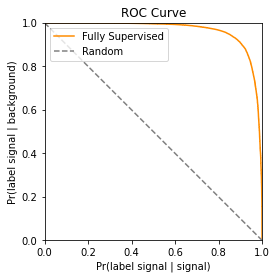

In [20]:
fpr_fs,tpr_fs,_=roc_curve(Y_fs_test,model_fs.predict(X_fs_test,batch_size=2000))

# Plot the ROC curve
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(tpr_fs,1.0-fpr_fs,color="darkorange",label='Fully Supervised')
plt.plot([0,1],[1,0],linestyle='--',color="gray",label="Random")
plt.xlabel("Pr(label signal | signal)")
plt.ylabel("Pr(label signal | background)")
plt.title("ROC Curve")
plt.axis([0,1,0,1])
plt.legend(loc="upper left")

In [21]:
## Anomaly detection

# weak supervision would be S+B versus B.  
# Let's do a simple unsupervised model, an autoencoder.

model_us = Sequential()
model_us.add(Dense(100,input_dim=4,activation='relu'))
model_us.add(Dense(4,activation='relu'))
model_us.add(Dense(100,activation='relu'))
model_us.add(Dense(4,activation='linear'))
model_us.compile(loss='mse',optimizer='adam')
model_us.summary()

X_us_train, X_us_test, Y_us_train, Y_us_test = train_test_split(back1,back1,test_size=0.5)
model_us.fit(X_us_train,Y_us_train,epochs=25,batch_size=2000)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               500       
                                                                 
 dense_5 (Dense)             (None, 4)                 404       
                                                                 
 dense_6 (Dense)             (None, 100)               500       
                                                                 
 dense_7 (Dense)             (None, 4)                 404       
                                                                 
Total params: 1,808
Trainable params: 1,808
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
39/39 [==============================] - 0s 5ms/step - loss: 0.8306
Epoch 2/25
39/39 [==============================] - 0s 5ms/step - loss: 0.3843
Epoch 3/25
39/39 [========

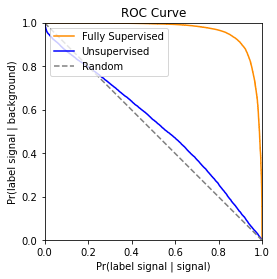

In [23]:
anomaly_score = np.linalg.norm(X_fs_test - model_us.predict(X_fs_test,batch_size=2000),axis=1)
fpr_us,tpr_us,_=roc_curve(Y_fs_test,anomaly_score)

# Plot the ROC curve
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(tpr_fs,1.0-fpr_fs,color="darkorange",label='Fully Supervised')
plt.plot(tpr_us,1.0-fpr_us,color="blue",label='Unsupervised')
plt.plot([0,1],[1,0],linestyle='--',color="gray",label="Random")
plt.xlabel("Pr(label signal | signal)")
plt.ylabel("Pr(label signal | background)")
plt.title("ROC Curve")
plt.axis([0,1,0,1])
plt.legend(loc="upper left")

### The performance is not great but it is unsupervised

In [10]:
anomaly_score

array([0.5728853 , 0.4767713 , 0.78907228, ..., 0.67447716, 1.07708857,
       0.77658118])

### Variational Auto Encoder

In [24]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda, Layer
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [25]:
def sample_z(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    eps = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(z_log_var / 2) * eps

In [26]:
from tensorflow.keras import backend as K

# Define loss
def myloss(y_true, y_pred):
    # mse
    sum_sq = (y_true-y_pred)*(y_true-y_pred)
    return K.sum(sum_sq, axis=-1)

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)
        self.add_loss(K.mean(kl_batch), inputs=inputs)
        return inputs

In [38]:
def vae(input_dim, latent_dim):
    #encoder
    input_encoder = Input(shape=(input_dim), name='encoder_input')
    x = Dense(10, activation='elu')(input_encoder)
    z_mu = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
    
    z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_log_var])
    encoder = Model(inputs=input_encoder, outputs=[z_mu, z_log_var, z], name='encoder')
    encoder.summary()
    
    #decoder
    input_decoder = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(10, activation='elu')(input_decoder)
    dec = Dense(input_dim, activation='linear')(x)    
    decoder = Model(inputs=input_decoder, outputs=dec, name='decoder')
    decoder.summary()
 
    #vae
    vae_outputs = decoder(encoder(input_encoder)[2])
    vae = Model(input_encoder, vae_outputs, name='vae')
    vae.summary()
    
    return vae, encoder

In [42]:
model, encoder = vae(4, 6)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 4)]          0           []                               
                                                                                                  
 dense_21 (Dense)               (None, 10)           50          ['encoder_input[0][0]']          
                                                                                                  
 dense_22 (Dense)               (None, 6)            66          ['dense_21[0][0]']               
                                                                                                  
 dense_23 (Dense)               (None, 6)            66          ['dense_21[0][0]']               
                                                                                            

In [43]:
model.compile(optimizer='adam', loss=myloss)

In [44]:
n_epochs = 200
batch_size = 128
# train 
history = model.fit(X_us_train, X_us_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_us_test, X_us_test),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/200
601/601 - 2s - loss: 4.2656 - val_loss: 3.3653 - lr: 0.0010 - 2s/epoch - 3ms/step
Epoch 2/200
601/601 - 2s - loss: 3.2730 - val_loss: 3.2122 - lr: 0.0010 - 2s/epoch - 3ms/step
Epoch 3/200
601/601 - 2s - loss: 3.1708 - val_loss: 3.1395 - lr: 0.0010 - 2s/epoch - 3ms/step
Epoch 4/200
601/601 - 2s - loss: 3.1289 - val_loss: 3.1200 - lr: 0.0010 - 2s/epoch - 3ms/step
Epoch 5/200
601/601 - 2s - loss: 3.1106 - val_loss: 3.1046 - lr: 0.0010 - 2s/epoch - 3ms/step
Epoch 6/200
601/601 - 2s - loss: 3.1002 - val_loss: 3.0981 - lr: 0.0010 - 2s/epoch - 3ms/step
Epoch 7/200
601/601 - 2s - loss: 3.0849 - val_loss: 3.0796 - lr: 0.0010 - 2s/epoch - 3ms/step
Epoch 8/200
601/601 - 2s - loss: 3.0835 - val_loss: 3.0812 - lr: 0.0010 - 2s/epoch - 3ms/step
Epoch 9/200
601/601 - 2s - loss: 3.0727 - val_loss: 3.0738 - lr: 0.0010 - 2s/epoch - 3ms/step
Epoch 10/200
601/601 - 2s - loss: 3.0656 - val_loss: 3.0718 - lr: 0.0010 - 2s/epoch - 3ms/step
Epoch 11/200
601/601 - 2s - loss: 3.0722 - val_loss: 3.0665

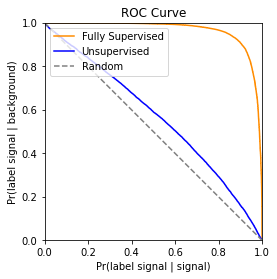

In [45]:
anomaly_score = np.linalg.norm(X_fs_test - model.predict(X_fs_test,batch_size=2000),axis=1)
fpr_us,tpr_us,_=roc_curve(Y_fs_test,anomaly_score)

# Plot the ROC curve
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(tpr_fs,1.0 -fpr_fs,color="darkorange",label='Fully Supervised')
plt.plot(tpr_us,1.0 - fpr_us,color="blue",label='Unsupervised')
plt.plot([0,1],[1,0],linestyle='--',color="gray",label="Random")
plt.xlabel("Pr(label signal | signal)")
plt.ylabel("Pr(label signal | background)")
plt.title("ROC Curve")
plt.axis([0,1,0,1])
plt.legend(loc="upper left")

#### It performs a bit better than AE but still the performance is much worse than fully supervised
